In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

## Check NaNs and Shape

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train.isna().sum(axis=1).value_counts().sort_index(ascending=False)

16      4
15      3
12      6
11     55
10     36
9       5
8       2
7      38
6     332
5     511
4     411
3      52
2       4
1       1
Name: count, dtype: int64

In [8]:
train.isna().mean().sort_values(ascending=False)[0:10]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64

In [9]:
test.isna().mean().sort_values(ascending=False)[0:10]

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
MasVnrType      0.612748
FireplaceQu     0.500343
LotFrontage     0.155586
GarageYrBlt     0.053461
GarageCond      0.053461
GarageFinish    0.053461
dtype: float64

---
### Pool Properties
---

In [10]:
train['PoolArea'].value_counts()

PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

In [11]:
train[['PoolQC','PoolArea']].dropna()

,PoolQC,PoolArea
197,Ex,512
810,Fa,648
1170,Gd,576
1182,Ex,555
1298,Gd,480
1386,Fa,519
1423,Gd,738



It is clear that most properties dont have a pool. And the spread in pool quality and area is not drastic or unreasonable: pools marked as fair are not always smaller, excellent pools are not always bigger. The main factor here will be: does the house have a pool. So we will convert these two features into a boolean for pool or no pool.

---
### Misc Feature

The same goes for MiscFeature and Alley

In [12]:
train['MiscFeature'].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [13]:
train['Alley'].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

--- 

### Fence

Feature description:  
  
  Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

Given the range in quality, it might be plausible that a wood / wire fence is more similar to no fence, so we will also binary encode this given there are 80% nans, but we choose where to place our cutoff.

In [14]:
train['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

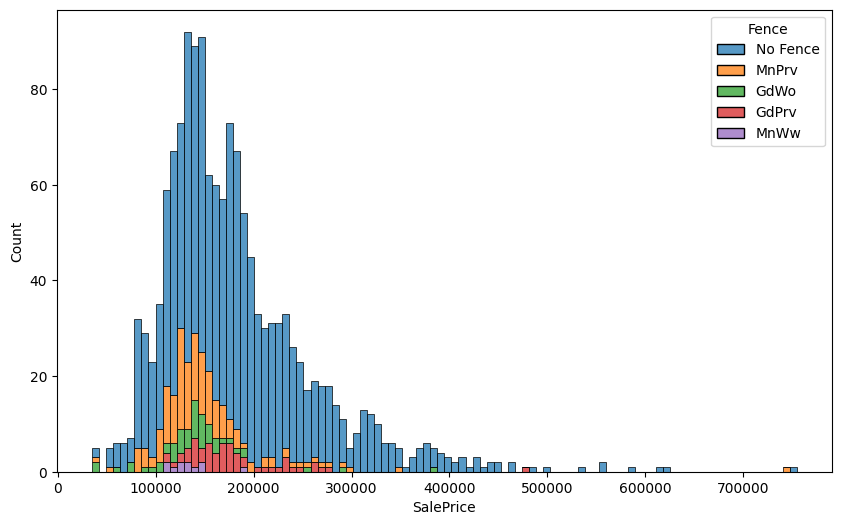

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

train['Fence'] = train['Fence'].fillna('No Fence')

sns.histplot(data=train, x='SalePrice', hue='Fence', multiple='stack', bins = 100)

plt.show()

The good privacy in red seems to have some value, but the rest match up with no fence. We will binary encode at this stage although could drop the entire feature later.

---

### Other small nan features


        MasVnrType      0.597260  

        FireplaceQu     0.472603  

        LotFrontage     0.177397  
  


In [16]:
train[['MasVnrType', 'FireplaceQu', 'LotFrontage']].nunique()

MasVnrType       3
FireplaceQu      5
LotFrontage    110
dtype: int64

#### MasVnrType

MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

<Axes: xlabel='SalePrice', ylabel='Count'>

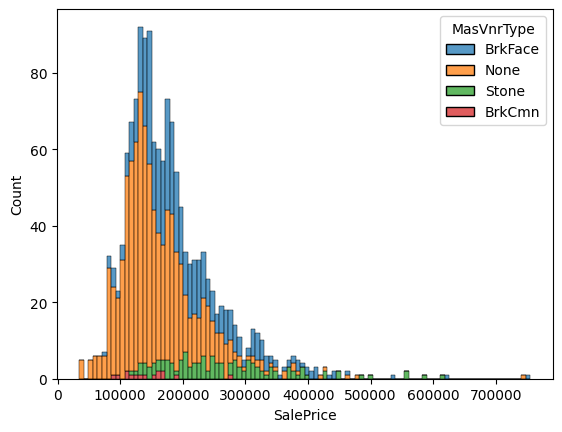

In [17]:
train['MasVnrType'] = train['MasVnrType'].fillna('None')

sns.histplot(data=train, x='SalePrice', hue='MasVnrType', multiple='stack', bins = 100)

Stone seems to distribute differently, which follows since stone is likely a more premium finish compared to the others. We will therefore encode with 'stone' = 1 and everything else as 0.

In [18]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
train['FireplaceQu'].value_counts()

FireplaceQu
None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: count, dtype: int64

In [19]:
train['Fireplaces'].value_counts()

Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64

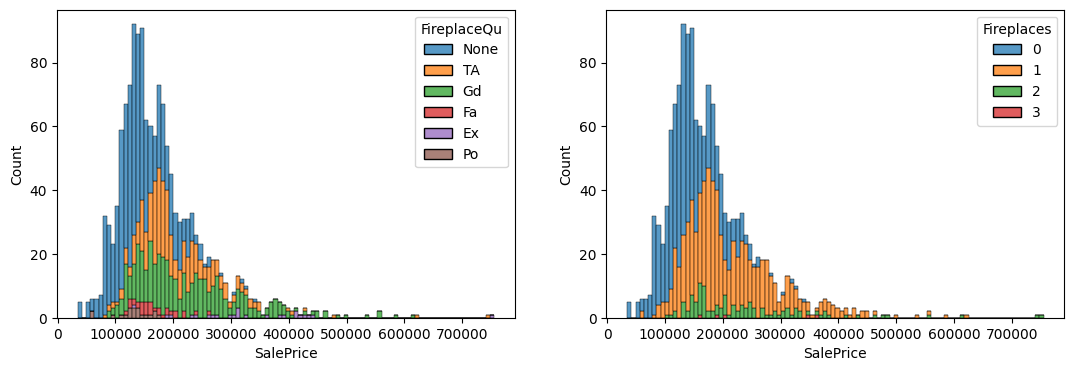

In [20]:
fig, ax = plt.subplots(1, 2,figsize=(13, 4))

sns.histplot(data=train, x='SalePrice', hue='FireplaceQu', multiple='stack', bins = 100, ax=ax[0])
sns.histplot(data=train, x='SalePrice', hue=train['Fireplaces'].astype(str), bins = 100, multiple='stack', ax=ax[1])

plt.show()



Across both plots, we see that those with fireplaces tend to have higher SalePrice. For simplicity across all our features, we will binary encode both of these also.

In [21]:
train['LotFrontage'].dtype

dtype('float64')

<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

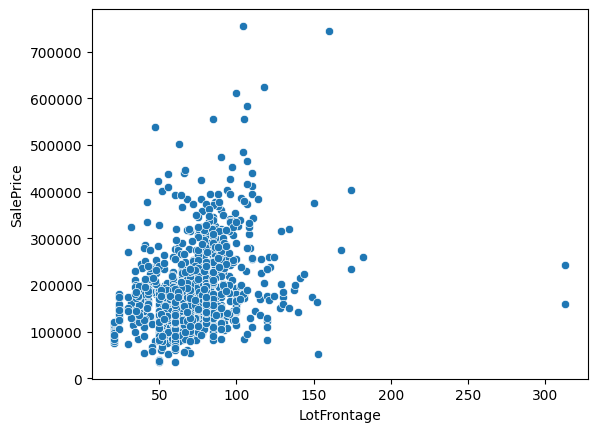

In [22]:
sns.scatterplot(data=train, x='LotFrontage', y='SalePrice')

Seems useful, we can impute with mean later on.

---

In [23]:
train_ec = data_prep.encode_nans(train)

train_ec.shape

(1460, 79)

In [24]:
train_ec.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [25]:
cat_df = pd.DataFrame()
for col in train_ec.select_dtypes(include=['object']).columns:
    cat_df.loc[col, 'max_cat'] = train_ec[col].value_counts(normalize=True).max()

above80 = cat_df[cat_df['max_cat'] > 0.8].sort_values(by='max_cat', ascending=False)
above80

,max_cat
Utilities,0.999315
Street,0.995890
Condition2,0.989726
RoofMatl,0.982192
Heating,0.978082
GarageCond,0.961566
GarageQual,0.950689
LandSlope,0.946575
CentralAir,0.934932
Functional,0.931507


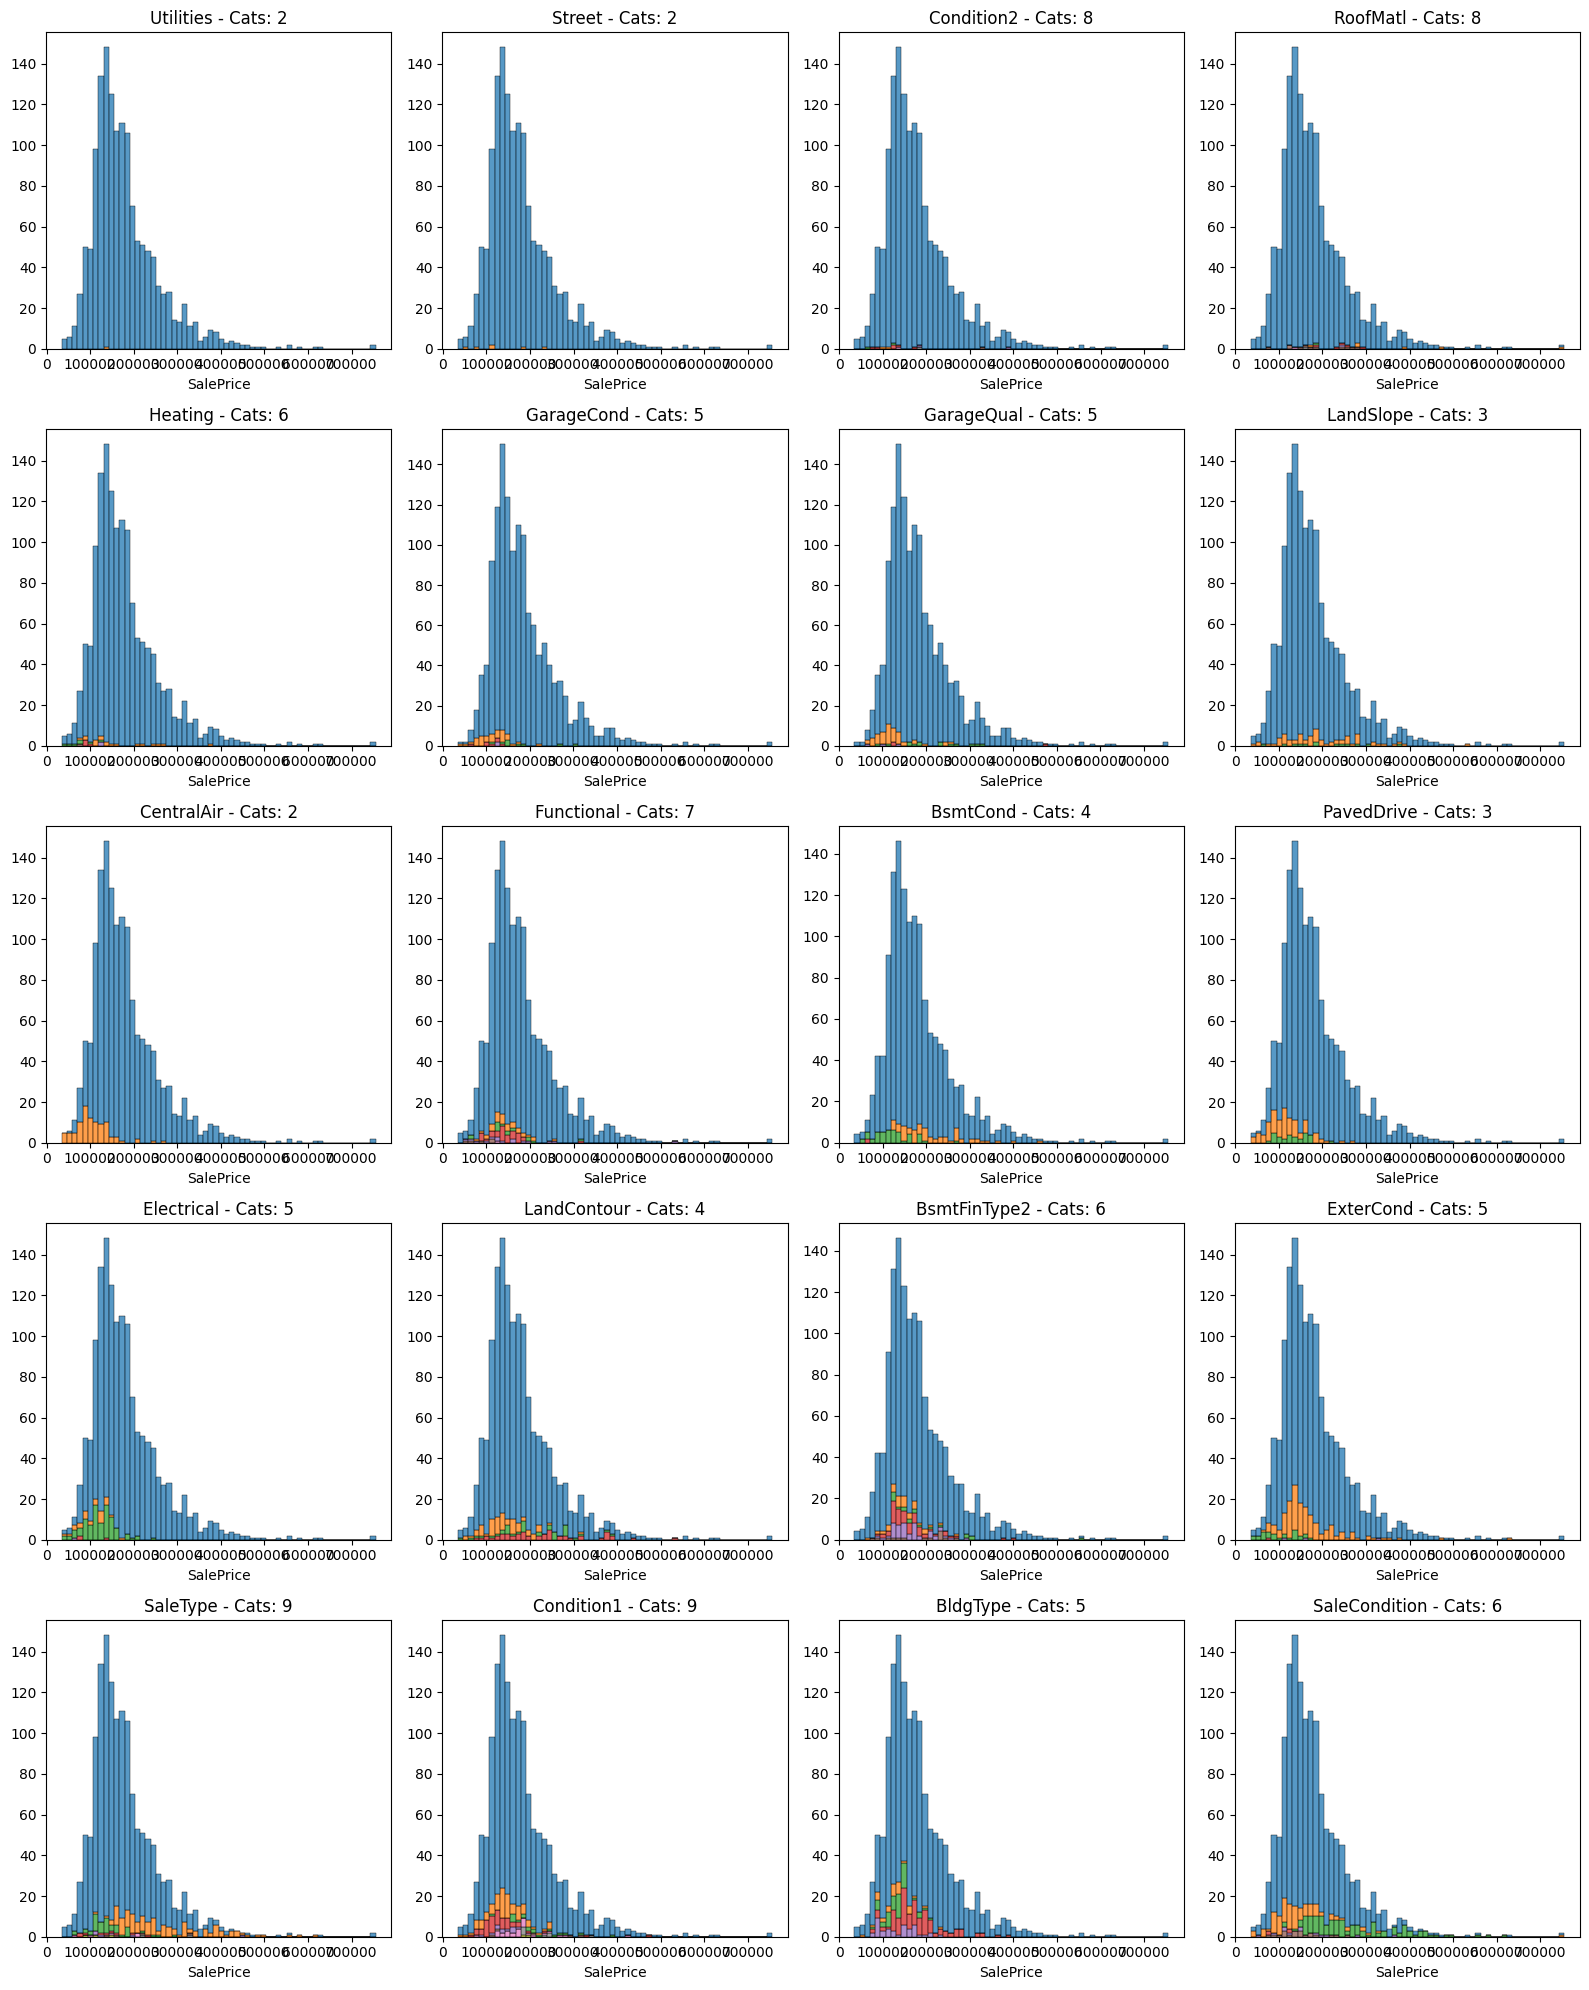

In [28]:
fig, ax = plt.subplots(5, 4, figsize=(16, 4*5))

flat_ax = ax.flatten()

for i, col in enumerate(above80.index):
    sns.histplot(data=train_ec, x='SalePrice', hue=col, multiple='stack', bins = 60, ax=flat_ax[i], legend=False)
    flat_ax[i].set_title(f'{col} - Cats: {train_ec[col].nunique()}')
    flat_ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

### Unbalanced categorical features:

Starting from the top, the first row are extremely unbalanced, and for roofmatl, the datapoints that can be seen lie directly under the median for the dominant category, so we will remove all four of these.  
  
The next row has heating which appears to be useful. Looking at the data description, the dominant class is a particular gas heating which must be most popular - people avoid unconventional heating. We will binary encode this with 1 as the dominant class. There are two features for garage, and also numerical features for garage. These are shown below. The other garage features appear quite useful, so we will drop these unbalanced garage features in favour of the other ones. 
  
We might expect landslope to have an impact on price, although the 'severe' category has very few datapoints, and from what we can see the moderate category isnt outlying so much. This is removed.  
  
CentralAir for air conditioning is clearly important. Binary encode.  

Functional, for house functionality tells us about damage to the house. Some samples exist for minor damage, although the severe damage categories are sparsely populated. Remove.  
  
BsmtCond. Other basement features, below, seem to have a greater bearing. Drop.  
  
PavedDrive. Categories have different distributions. Binary Encode.  
  
Electrical. Encode.  
  
After this, the rest of the columns seem to have a balance between the categories. We choose to OneHotEncode them, using a custom transformer to group classes which make up less than 8% of the dataset.

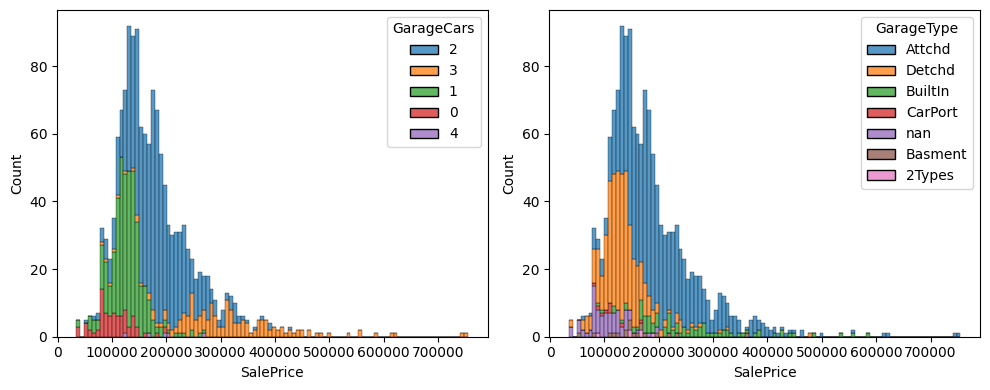

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['GarageCars'].astype(str), multiple='stack', bins = 100, ax=ax[0])
sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['GarageType'].astype(str), multiple='stack', bins = 100, ax=ax[1])

plt.tight_layout()
plt.show()

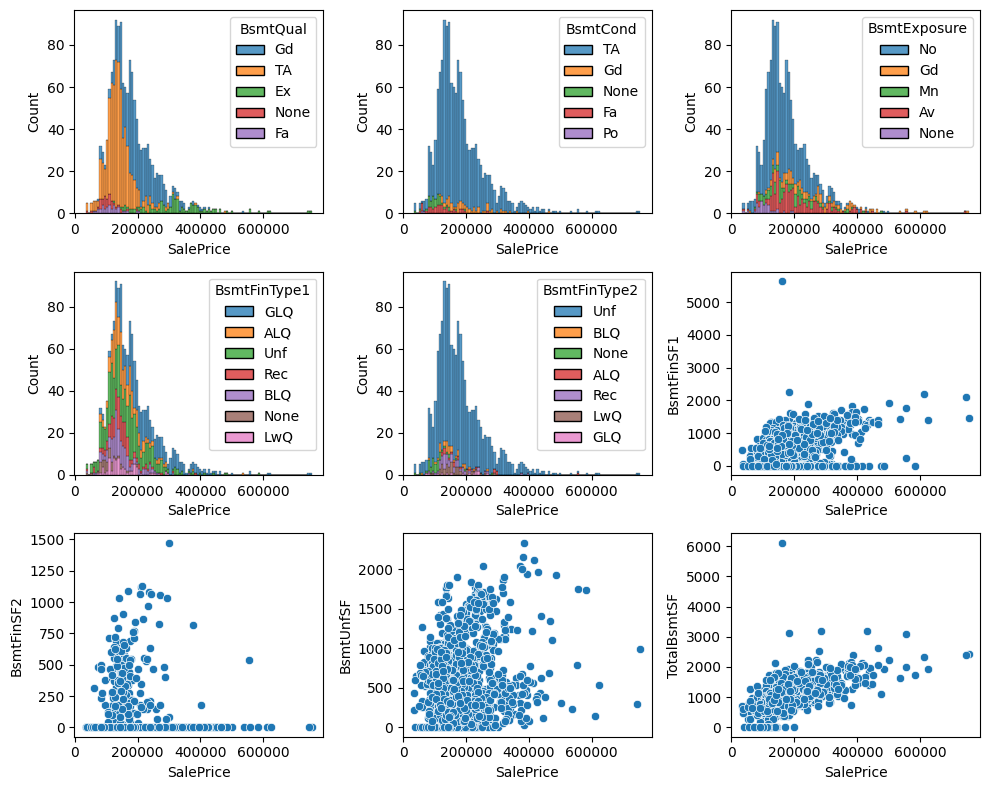

In [30]:
train_ec['BsmtQual'] = train_ec['BsmtQual'].fillna('None')
train_ec['BsmtCond'] = train_ec['BsmtCond'].fillna('None')
train_ec['BsmtExposure'] = train_ec['BsmtExposure'].fillna('None')
train_ec['BsmtFinType1'] = train_ec['BsmtFinType1'].fillna('None')
train_ec['BsmtFinType2'] = train_ec['BsmtFinType2'].fillna('None')

fig, ax = plt.subplots(3, 3, figsize=(10, 8))

sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['BsmtQual'], multiple='stack', bins = 100, ax=ax[0,0]) #1 cat
sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['BsmtCond'], multiple='stack', bins = 100, ax=ax[0,1]) #2 cat
sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['BsmtExposure'], multiple='stack', bins = 100, ax=ax[0,2]) #3 cat
sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['BsmtFinType1'], multiple='stack', bins = 100, ax=ax[1,0]) #4 cat
sns.histplot(data=train_ec, x='SalePrice', hue=train_ec['BsmtFinType2'], multiple='stack', bins = 100, ax=ax[1,1]) #5 cat
sns.scatterplot(data=train_ec, x='SalePrice', y='BsmtFinSF1', ax=ax[1,2]) #6 num
sns.scatterplot(data=train_ec, x='SalePrice', y='BsmtFinSF2', ax=ax[2,0]) #7 num
sns.scatterplot(data=train_ec, x='SalePrice', y='BsmtUnfSF', ax=ax[2,1]) #8 num
sns.scatterplot(data=train_ec, x='SalePrice', y='TotalBsmtSF', ax=ax[2,2]) #9 num

plt.tight_layout()
plt.show()

---
## Numerical Columns

In [212]:
numeric = train[train.select_dtypes(include=['number']).columns]

In [213]:
numeric

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


---

## Creating Pipeline

In [263]:
class NonNaNIndicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def set_output(self, transform=None):
        return self

    def transform(self, X):
        indicators = X.notna().astype(int)
        indicators.columns = [f"{col}_nonan" for col in X.columns]
        return indicators
    

class FillNAString(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, fill_value="__MISSING__"):
        self.columns = columns  # if None, auto-detect in fit
        self.fill_value = fill_value

    def fit(self, X, y=None):
        if self.columns is None:
            # Only apply to object or category columns
            self.columns_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
        else:
            self.columns_ = self.columns
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns_:
            X[col] = X[col].fillna(self.fill_value)
        return X

    def set_output(self, transform=None):
        return self




class GroupPresenceIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, output_column_name="has_feature"):
        self.output_column_name = output_column_name

    def fit(self, X, y=None):
        return self

    def set_output(self, transform=None):
        return self

    def transform(self, X):
        has_feature = X.notna().any(axis=1).astype(int)
        return pd.DataFrame({self.output_column_name: has_feature}, index=X.index)
    

class CategoricalMatchIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, column, match_value, output_column=None):
        self.column = column
        self.match_value = match_value
        self.output_column = output_column or f"{column}_is_{match_value}"
    
    def fit(self, X, y=None):
        return self
    
    def set_output(self, transform=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.output_column] = (X[self.column] == self.match_value).astype(int)
        X.drop(columns=[self.column], inplace=True)
        return X

    
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def set_output(self, transform=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)
    

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class RareCategoryOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=0.08, rare_label="__RARE__", drop='if_binary'):
        self.columns = columns
        self.threshold = threshold
        self.rare_label = rare_label
        self.drop = drop
        self.category_maps_ = {}
        self.output_columns_ = []

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            freq = X[col].value_counts(normalize=True)
            common = freq[freq >= self.threshold].index
            self.category_maps_[col] = set(common)

        # Simulate transformed data to lock in column structure
        transformed = self._onehot_transform(X)
        self.output_columns_ = transformed.columns.tolist()
        return self

    def transform(self, X):
        transformed = self._onehot_transform(X)
        return transformed[self.output_columns_]  # Keep columns in fit order

    def _onehot_transform(self, X):
        X = X.copy()
        out = []

        for col in self.columns:
            common = self.category_maps_.get(col, set())
            col_replaced = X[col].where(X[col].isin(common), self.rare_label)

            # Handle drop options
            drop_first = False
            if self.drop == 'first':
                drop_first = True
            elif self.drop == 'if_binary' and col_replaced.nunique() == 2:
                drop_first = True

            dummies = pd.get_dummies(col_replaced, prefix=col, drop_first=drop_first, dtype=int)
            out.append(dummies)

        return pd.concat(out, axis=1)

    def set_output(self, transform=None):
        return self
    

class ColumnAligner(BaseEstimator, TransformerMixin):
    def __init__(self, expected_columns=None):
        self.expected_columns = expected_columns
        
    def fit(self, X, y=None):
        if self.expected_columns is None:
            self.expected_columns = X.columns.tolist()
        return self
        
    def transform(self, X):
        # Add missing columns with zeros
        for col in self.expected_columns:
            if col not in X.columns:
                X[col] = 0
        # Remove extra columns and reorder
        return X[self.expected_columns]
    
    def set_output(self, transform=None):
        return self
    

all_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']

remaining_cols = ['MSZoning','LotShape','LandContour','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','ExterQual','ExterCond','Foundation','HeatingQC','KitchenQual','GarageType','GarageFinish','GarageQual','GarageCond','SaleType','SaleCondition','FireplaceQu','PoolQC','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2']


preprocessor = ColumnTransformer(
    transformers=[
        #("pool", GroupPresenceIndicator("has_pool"), ['PoolQC', 'PoolArea']),
        #("fireplace", GroupPresenceIndicator("has_fireplace"), ['FireplaceQu', 'Fireplaces']),
        ("nonnan", NonNaNIndicator(), ['MiscFeature', 'Alley', 'Fence']),
        ("mas_vnr", CategoricalMatchIndicator('MasVnrType', 'Stone'), ['MasVnrType']),
        ("heating", CategoricalMatchIndicator('Heating', 'GasA'), ['Heating']),
        ("1hot_dpbn", OneHotEncoder(drop='if_binary', sparse_output=False), ['CentralAir','PavedDrive']),
        ("rare_gp", RareCategoryOneHotEncoder(columns=['Electrical'],threshold=0.05, drop='if_binary'), ['Electrical']),
        ("rare_rest", RareCategoryOneHotEncoder(columns=remaining_cols,threshold=0.08, drop='if_binary'), remaining_cols),
    ],
    remainder="passthrough"
)

full_pipeline = Pipeline([
    ("fillna", FillNAString()),
    ("drop", DropColumns(['Utilities', 'Street', 'RoofMatl', 'Condition2', 'LandSlope','Functional','BsmtCond','PoolArea','Fireplaces'])),
    ("preprocessor", preprocessor),
    ("aligner", ColumnAligner()),
])

full_pipeline.set_output(transform='pandas')


Pipeline(steps=[('fillna', FillNAString()),
                ('drop',
                 DropColumns(columns=['Utilities', 'Street', 'RoofMatl',
                                      'Condition2', 'LandSlope', 'Functional',
                                      'BsmtCond', 'PoolArea', 'Fireplaces'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nonnan', NonNaNIndicator(),
                                                  ['MiscFeature', 'Alley',
                                                   'Fence']),
                                                 ('mas_vnr',
                                                  CategoricalMatchIndicator(c...
                                                   'LandContour', 'LotConfig',
                                                   'Neighborhood', 'Condition1',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Exterior1st',
                                                   'Exterior2nd', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'HeatingQC', 'KitchenQual',
                                                   'GarageType', 'GarageFinish',
                                                   'GarageQual', 'GarageCond',
                                                   'SaleType', 'SaleCondition',
                                                   'FireplaceQu', 'PoolQC',
                                                   'BsmtQual', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2'])])),
                ('aligner', ColumnAligner())])

---

In [264]:
price = train['SalePrice']
train_dropped = train.drop(columns=['SalePrice', 'Id'])
fp = full_pipeline.fit_transform(train_dropped)

In [266]:
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [267]:
x_train, x_test, y_train, y_test = train_test_split(fp, price, test_size=0.2, random_state=42)

In [301]:
model = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.015,
    max_depth=0,                 # ignored when using max_leaves
    max_leaves=512,
    grow_policy="lossguide",
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=0.2,
    reg_lambda=3.0,
    tree_method="hist",
    eval_metric="rmse",
    random_state=42
)


model.fit(x_train, y_train)

preds = model.predict(x_test)

from sklearn.metrics import mean_squared_error

In [302]:
y_pred = model.predict(x_test)

In [303]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



In [304]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse

671794496.0

In [305]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.9124164581298828

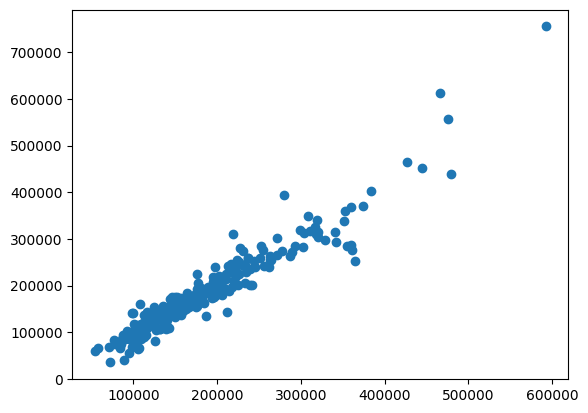

In [306]:
plt.scatter(y_pred, y_test)

--- 
## CatBoost

In [293]:
from catboost import CatBoostRegressor

In [294]:
model_cat = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
)

In [295]:
y_train.nunique()

571

In [296]:
model_cat.fit(x_train, y_train)

0:	learn: 72308.5212810	total: 151ms	remaining: 1m 15s
100:	learn: 15578.7086092	total: 685ms	remaining: 2.71s
200:	learn: 10248.9830459	total: 1.85s	remaining: 2.76s
300:	learn: 7364.9444753	total: 3.43s	remaining: 2.27s
400:	learn: 5518.4466600	total: 4.9s	remaining: 1.21s
499:	learn: 4323.0421367	total: 6.36s	remaining: 0us


In [297]:
y_pred_cat = model_cat.predict(x_test)

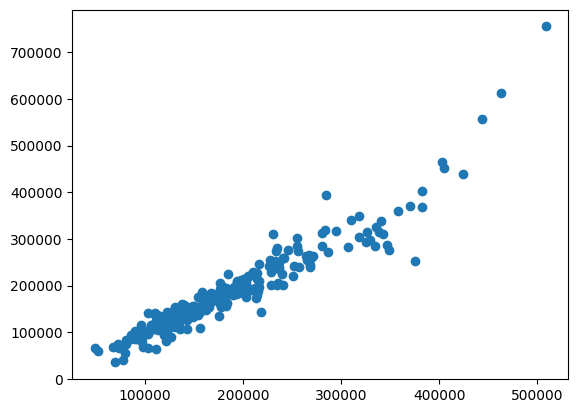

In [298]:
plt.scatter(y_pred_cat, y_test)

---
## Submission

In [274]:
test = pd.read_csv('test.csv')

In [275]:
test_id = test['Id']
test2 = test.drop(columns=['Id'])

In [276]:
test_transformed = full_pipeline.transform(test2)

c:\Users\olive\miniconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [281]:
cl = ColumnAligner(expected_columns=fp.columns)

In [283]:
test_transformed_aligned = cl.transform(test_transformed)

In [307]:
preds = model.predict(test_transformed_aligned)

In [308]:
sub = pd.DataFrame({'Id': test_id, 'SalePrice': preds})
sub.to_csv('submissions/sub_pipeline_xgbtuned.csv', index=False)